In [207]:
import numpy as np
from sklearn.neighbors import kneighbors_graph
from tensorflow.keras.datasets import mnist 
import tensorflow as tf
from tensorflow import keras
import sys
from tensorflow.keras import layers
from keras import Input, Model
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Flatten
from keras.optimizers import Adam
from keras.regularizers import l2

tf.keras.backend.set_floatx('float64')

np.set_printoptions(threshold=sys.maxsize)

MNIST_SIZE = 28

# 필요한 것 체크

1. 데이터 ( mnist )
2. mnist adjacency matrix
3. mnist feature matrix
4. matmul ( feature matrix - weighted matrix )
5. matmul ( matmul ( feature matrix - weighted matrix ) - adjacency matrix )
6. non linear activation ( matmul outputs )

# Adjacency matrix + Feature matrix

In [240]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Feature map normalization & reshape (784 nodes, 1 feature)

x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = x_train.reshape(-1, MNIST_SIZE ** 2, 1)
x_test = x_test.reshape(-1, MNIST_SIZE ** 2, 1)

In [241]:
M = 28 ** 2
x = np.linspace(0, 1, 28, dtype=np.float32)
y = np.linspace(0, 1, 28, dtype=np.float32)
    # meshgrid를 통해 행렬을 생성
xx, yy = np.meshgrid(x, y)
    # 784, 2 크기의 array를 생성, x와 y를 담기 위한 shape
z = np.empty((784, 2), np.float32)
    # 아까 meshgrid를 통해 생성한 array를 평평하게 펴서 z에 넣음
z[:, 0] = xx.reshape(784)
z[:, 1] = yy.reshape(784)

In [242]:
from sklearn.neighbors import kneighbors_graph

# array z를 통해 8개의 이웃을 갖는 희소 행렬을 반환
# 유클리드 거리를 기준으로 계산거리를 기준으로 계산
A_mat = kneighbors_graph(z, 8).toarray()

In [244]:
print(x_train.shape, x_test.shape, A_mat.shape)
print(y_train.shape, y_test.shape)

(60000, 784, 1) (10000, 784, 1) (784, 784)
(60000,) (10000,)


# Graph Convolutional

In [245]:
# Graph Convolution Layer를 정의

def graph_conv(_X, _A, output_dim):
    X = tf.keras.layers.Dense(units=output_dim, use_bias=True, kernel_regularizer=l2(l2_reg))(_X)
    output = tf.matmul(_A, X)
    output = tf.keras.activations.relu(output)
    return output

In [246]:
# Parameters
l2_reg = 5e-4         # Regularization rate for l2
learning_rate = 1e-3  # Learning rate 
batch_size = 32       # Batch size
epochs = 5        # Number of training epochs

In [247]:
N = x1.shape[-2]    # Number of nodes in the graphs
F = x1.shape[-1]    # Node features dimensionality
n_out = 10          # Dimension of the target

print(N, F)

784 1


In [248]:
# Input shape is Node x Feature
# Feature matrix
X_in = Input(shape=(N, F))

In [249]:
# Input = Feature matrix, Adjacency matrix, dimension
graph_conv_1 = graph_conv(X_in, A_mat, 32)
graph_conv_2 = graph_conv(graph_conv_1, A_mat, 64)

In [250]:
# num_classes = 10 ( mnist classification )
flatten = Flatten()(graph_conv_2)
fc = Dense(128, activation='relu')(flatten)
output = Dense(n_out, activation='softmax')(fc)

In [251]:
model = Model(inputs=X_in, outputs=output)
optimizer = Adam(lr=learning_rate)

# label이 onehot이라면 categorical cross entropy를 사용
# 최하단 layer의 activation 여부에 따라 from_logits 매개변수 True or False
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [252]:
model.summary()

Model: "functional_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        [(None, 784, 1)]          0         
_________________________________________________________________
dense_58 (Dense)             (None, 784, 32)           64        
_________________________________________________________________
tf_op_layer_BatchMatMulV2_25 [(None, 784, 32)]         0         
_________________________________________________________________
tf_op_layer_Relu_25 (TensorF [(None, 784, 32)]         0         
_________________________________________________________________
dense_59 (Dense)             (None, 784, 64)           2112      
_________________________________________________________________
tf_op_layer_BatchMatMulV2_26 [(None, 784, 64)]         0         
_________________________________________________________________
tf_op_layer_Relu_26 (TensorF [(None, 784, 64)]       

In [253]:
model.fit(x_train,
          y_train,
          batch_size=batch_size,
          epochs=epochs,)

Epoch 1/5
1875/1875 [==============================] - 111s 59ms/step - loss: 0.6230 - accuracy: 0.8973s - loss: 0.6235 - accuracy
Epoch 2/5
1875/1875 [==============================] - 118s 63ms/step - loss: 0.1881 - accuracy: 0.9448
Epoch 3/5
1875/1875 [==============================] - 122s 65ms/step - loss: 0.1502 - accuracy: 0.9562
Epoch 4/5
1875/1875 [==============================] - 123s 66ms/step - loss: 0.1226 - accuracy: 0.9640
Epoch 5/5
1875/1875 [==============================] - 123s 66ms/step - loss: 0.1032 - accuracy: 0.9694


In [254]:
print('Evaluating model.')
eval_results = model.evaluate(x_test,
                              y_test,
                              batch_size=batch_size)
print('Test loss: {}\n'
      'Test acc: {}'.format(*eval_results))

Evaluating model.
313/313 [==============================] - 10s 32ms/step - loss: 0.1274 - accuracy: 0.9646
Test loss: 0.12736225782221172
Test acc: 0.9646


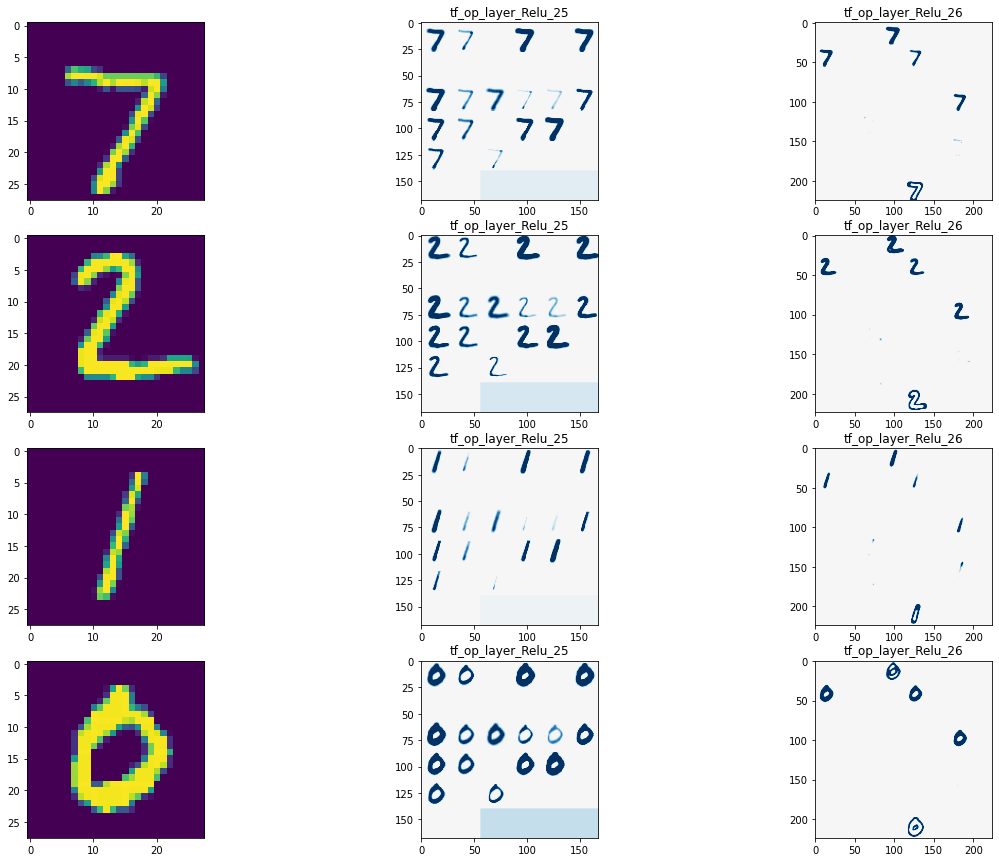

In [259]:
import matplotlib.pyplot as plt
from skimage.util import montage

i_model = Model(inputs=X_in, outputs=[graph_conv_1, graph_conv_2])
gc1_out, gc2_out = i_model.predict(x_test[:32])

fig, m_axs = plt.subplots(4, 3, figsize=(20, 15))
for i, (ax1, ax2, ax3) in enumerate(m_axs):
    ax1.imshow(x_test[i].reshape((28, 28)))
    gc_stack = gc1_out[i].reshape((28, 28, -1)).swapaxes(0, 2).swapaxes(1, 2)
    ax2.imshow(montage(gc_stack), vmin=-0.5, vmax=0.5, cmap='RdBu')
    ax2.set_title(i_model.output_names[0])
    gc_stack = gc2_out[i].reshape((28, 28, -1)).swapaxes(0, 2).swapaxes(1, 2)
    ax3.imshow(montage(gc_stack), vmin=-0.5, vmax=0.5, cmap='RdBu')
    ax3.set_title(i_model.output_names[1])